In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)
from tqdm import tqdm
import datetime
from itertools import combinations
from collections import Counter
import itertools
import re

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import Binarizer
from sklearn.ensemble import RandomForestClassifier



from sklearn.metrics import precision_score , recall_score , f1_score
import lightgbm as lgb
from scipy import stats
from scipy.spatial.distance import mahalanobis
from catboost import Pool, CatBoostClassifier

In [3]:
data_train = pd.read_csv('/Users/s0c02nj/Desktop/Mortgage Modelling/CAX_MortgageModeling_Train.csv')
data_test =  pd.read_csv('/Users/s0c02nj/Desktop/Mortgage Modelling/CAX_MortgageModeling_Test.csv')
data_sub =   pd.read_csv('/Users/s0c02nj/Desktop/Mortgage Modelling/CAX_MortgageModeling_SubmissionFormat.csv')

In [4]:
data_train = data_train.drop(['Unique_ID','MORTGAGE NUMBER'],axis=1)
data_test =  data_test.drop(['Unique_ID','MORTGAGE NUMBER','RESULT'], axis=1)

In [5]:
#Train data separating the response
y       = data_train['RESULT']
x_train = data_train.drop(['RESULT'],axis=1)


In [6]:
#Test data and train data merged for pre-processing
x_comb = pd.concat([x_train,data_test],sort=False)

Replacing negative value in GDS by 0

In [7]:
x_comb[x_comb['GDS'] < 0] = 0

In [8]:
corr_prop = []

for i in tqdm(range(0,len(x_comb))):
    
    ltv_val = x_comb['LTV'].iloc[i]
    mort    = x_comb['MORTGAGE AMOUNT'].iloc[i]
    prop    = x_comb['PROPERTY VALUE'].iloc[i]
    
    if mort != (ltv_val * prop) :
        val = mort/(ltv_val/100.0)
        corr_prop.append(val)
    
    else :
        corr_prop.append(prop)

100%|██████████| 60856/60856 [00:04<00:00, 13222.51it/s]


In [9]:
x_comb['PROPERTY VALUE'] = corr_prop

In [11]:
cont_cols = ['PROPERTY VALUE','MORTGAGE PAYMENT','GDS','LTV','TDS','AMORTIZATION','MORTGAGE AMOUNT',
             'INCOME','CREDIT SCORE','RATE']

In [12]:
cat_cols = ['PAYMENT FREQUENCY','PROPERTY TYPE','FSA','TERM','AGE RANGE','GENDER','INCOME TYPE',
           'NAICS CODE','MORTGAGE PURPOSE']

In [13]:
#Adaptive Bining
quantile_list = [0, .25, .5, .75, 1.]
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']

ada_bin=[]
for col in tqdm(cont_cols):
    
    ada_bin.append(str(col)+'ada_bin')
    x_comb[str(col)+'ada_bin'] =    pd.qcut(x_comb[col].rank(method='first'), 
                                            q=quantile_list,
                                            labels=quantile_labels)

100%|██████████| 10/10 [00:00<00:00, 54.80it/s]


In [14]:
# cat_cols_new = ['PROPERTY_TYPE','FSA','TERM','AGE_RANGE','GENDER','INCOME_TYPE',
#            'NAICS_CODE','MORTGAGE_PURPOSE']

In [15]:
log_transformed = ['PROPERTY VALUE','MORTGAGE PAYMENT','LTV','INCOME','CREDIT SCORE','MORTGAGE AMOUNT']

In [16]:
non_log_cols = ['GDS','LTV','TDS','AMORTIZATION','RATE']

In [17]:
for col in tqdm(cat_cols):
    le = LabelEncoder()
    x_comb[col] = le.fit_transform(x_comb[col])

100%|██████████| 9/9 [00:00<00:00, 28.97it/s]


In [18]:
z=[]
for col in tqdm(cat_cols):
    z.append((col,x_comb[col].unique().shape))

100%|██████████| 9/9 [00:00<00:00, 1280.75it/s]


In [19]:
#Label Encoding the y-var
le_y = LabelEncoder()

y_cat = le_y.fit_transform(y)

In [20]:
x_comb.skew()

PROPERTY VALUE         5.197463
MORTGAGE PAYMENT       4.115295
GDS                  180.294731
LTV                   -2.072901
TDS                  154.046537
AMORTIZATION          -8.411901
MORTGAGE AMOUNT        3.648115
RATE                   0.321268
MORTGAGE PURPOSE       0.103036
PAYMENT FREQUENCY     -4.059931
PROPERTY TYPE         -0.540880
TERM                   2.207522
FSA                    0.515754
AGE RANGE              0.366293
GENDER                 0.159848
INCOME                 6.560572
INCOME TYPE            0.608504
NAICS CODE            -0.303604
CREDIT SCORE          -3.073395
dtype: float64

RESULT
FUNDED        [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
NOT FUNDED    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
dtype: object

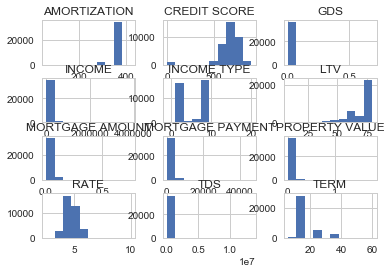

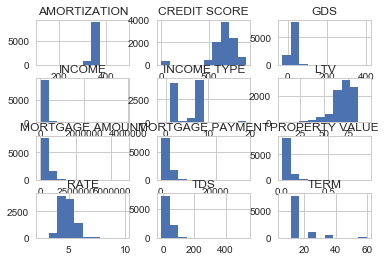

In [21]:
data_train.groupby('RESULT').hist()

In [22]:
#plt.hist(data_train[data_train['RESULT'] == 'NOT FUNDED']['AMORTIZATION'])

In [23]:
#plt.hist(data_train[data_train['RESULT'] == 'FUNDED']['AMORTIZATION'])

In [24]:
#Features for LTV
ind_ltv = []
for i in tqdm(range(0,len(x_comb))):
    ltv_val = x_comb['LTV'].iloc[0]
    
    if ltv_val>=55 and ltv_val<=78 :
        ind_ltv.append(1)
    else :
        ind_ltv.append(0)

100%|██████████| 60856/60856 [00:01<00:00, 36477.90it/s]


In [ ]:
x_comb['ind_ltv']= ind_ltv

In [ ]:
#Features for TDS
ind_tds_bin1 = []

for i in tqdm(range(0,len(x_comb))):
    tds_val = x_comb['TDS'].iloc[0]
    
    if tds_val>=40 and tds_val<=100:
        ind_tds_bin1.append(1)
    else :
        ind_tds_bin1.append(0)


In [ ]:
x_comb['ind_tds_bin1'] = ind_tds_bin1

In [ ]:
#Features for GDS
ind_tds_bin2 = []

for i in tqdm(range(0,len(x_comb))):
    tds_val = x_comb['GDS'].iloc[0]
     
    if tds_val<0 :
        ind_tds_bin2.append(0)
    
    if tds_val>=0 and tds_val<40:
        ind_tds_bin2.append(1)
    
    elif tds_val>=40 and tds_val<100:
        ind_tds_bin2.append(2)
    
    elif tds_val>=100 and tds_val<200:
        ind_tds_bin2.append(3)
    
    else :
        ind_tds_bin2.append(4)

In [ ]:
x_comb['ind_tds_bin2'] = ind_tds_bin2

In [ ]:
#Features for GDS
ind_am_bin2 = []

for i in tqdm(range(0,len(x_comb))):
    tds_am = x_comb['AMORTIZATION'].iloc[0]
     
    if tds_am<150 :
        ind_am_bin2.append(0)
    
    if tds_am>=150 and tds_am<200:
        ind_am_bin2.append(1)
    
    elif tds_am>=200 and tds_am<300:
        ind_am_bin2.append(2)
    
    elif tds_am>=300 and tds_am<350:
        ind_am_bin2.append(3)
    
    else :
        ind_am_bin2.append(4)

In [ ]:
x_comb['ind_am_bin2'] = ind_am_bin2

In [ ]:
new_cols = ['ind_ltv','ind_gds_bin1','ind_gds_bin2','ind_tds_bin1','ind_tds_bin2','ind_am_bin2']

In [ ]:
#cat_cols = cat_cols + new_cols

In [25]:
for col in log_transformed:
    x_comb[col] = np.log1p(x_comb[col])
    

In [26]:
#cont_cols = cont_cols + log_transformed

In [27]:
col_count = []

for col in tqdm(cont_cols):
    counter = Counter(x_comb[col])
    col_count.append(str(col)+'count')
    x_comb[str(col)+'count'] = x_comb[col].apply(lambda x:counter[x])

100%|██████████| 10/10 [00:00<00:00, 11.83it/s]


In [28]:
aggs = {}

aggs['MORTGAGE PAYMENT'] = ['median', 'mean','std']
aggs['GDS'] = ['median', 'mean','std']
aggs['LTV'] = ['median', 'mean','std']
aggs['TDS'] = ['median', 'mean','std']
aggs['AMORTIZATION'] = ['median', 'mean','std']
aggs['INCOME'] = ['median', 'mean','std']
aggs['CREDIT SCORE'] = ['median', 'mean','std']
aggs['MORTGAGE AMOUNT'] = ['median', 'mean','std']
aggs['PROPERTY VALUE'] = ['median', 'mean','std']
aggs['RATE'] = ['median', 'mean','std']
aggs['PAYMENT FREQUENCY'] = ['count','mean','median']
aggs['PROPERTY TYPE'] = ['count','mean','median']
aggs['FSA'] = ['count','mean','median']
aggs['TERM'] = ['count','mean','median']
aggs['AGE RANGE'] = ['count','mean','median']
aggs['GENDER'] = ['count','mean','median']
aggs['INCOME TYPE'] = ['count','mean','median']
aggs['NAICS CODE'] = ['count','mean','median']
aggs['MORTGAGE PURPOSE'] = ['count','mean','median']


for col in tqdm(cat_cols):
    agg_df = x_comb.groupby(col).agg(aggs).reset_index()
    agg_df.columns = [col] + [col + '_' + c[0] +'_' + c[1] for c in agg_df.columns[1:]]
    x_comb = pd.merge(x_comb, agg_df, on=col, how="left")

100%|██████████| 9/9 [00:04<00:00,  1.74it/s]


In [29]:
#Continuous-continuous features
list_cont_cont = list(combinations(cont_cols,2))

for cols in tqdm(list_cont_cont):
    col1 = cols[0]
    col2 = cols[1]
    x_comb[col1+col2+'sum'] =  x_comb[col1]+x_comb[col2]
    x_comb[col1+col2+'mult'] = x_comb[col1]*x_comb[col2]
    x_comb[col1+col2+'div1'] = x_comb[col1]/x_comb[col2]
    x_comb[col1+col2+'div2'] = x_comb[col2]/x_comb[col1]
    x_comb[col1+col2+'sub'] =  x_comb[col1] - x_comb[col2]

100%|██████████| 45/45 [00:01<00:00, 31.60it/s]


In [30]:
#Categorical-Categorical features
list_cat_cat = list(combinations(cat_cols,2))

for cols in tqdm(list_cat_cat):
    col1 = cols[0]
    col2 = cols[1]
    x_comb['cat'+col1+col2+'mult'] = x_comb[col1]*x_comb[col2]
            

100%|██████████| 36/36 [00:00<00:00, 557.22it/s]


In [31]:
#Categorical-Categorical features
# list_cat_cat2 = list(combinations(cat_cols,3))

# for cols in tqdm(list_cat_cat2):
#     col1 = cols[0]
#     col2 = cols[1]
#     col3 = cols[2]
#     x_comb['cat3'+col1+col2+col3+'mult'] = x_comb[col1]*x_comb[col2]*x_comb[col3]
            

In [32]:
#Categorical-Categorical features
# list_cont_cont2 = list(combinations(cont_cols,3))

# for cols in tqdm(list_cont_cont2):
#     col1 = cols[0]
#     col2 = cols[1]
#     col3 = cols[2]
#     x_comb['cont3'+col1+col2+col3+'mult'] = x_comb[col1]*x_comb[col2]*x_comb[col3]
            

In [33]:
#Categorical-continuous
list_cat_cont = list(itertools.product(cat_cols, cont_cols))

for cols in tqdm(list_cat_cont):
    col1 = cols[0]
    col2 = cols[1]
    x_comb['cat_cont'+col1+col2+'mult'] = x_comb[col1]*x_comb[col2]

100%|██████████| 90/90 [00:00<00:00, 128.56it/s]


In [35]:
train_x = x_comb[0:45642]
test_x =  x_comb[45642:]

In [47]:
x1_train, x1_val, y1_train, y1_val = train_test_split(train_x, y_cat,test_size=0.2,random_state=42,
                                                      stratify = y)
                                                      

In [48]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [1]:
random_state = 42


lgb_params = {
    "objective" : "binary",
    'metric':{lgb_f1_score},
    "boosting": 'gbdt',
    "max_depth" : 6,
    "num_leaves" : 30,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.6,
    "feature_fraction" : 0.1,
    "min_data_in_leaf":  40,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    'min_split_gain': .001,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "is_unbalance":'TRUE',
    "seed": 42
}

NameError: name 'lgb_f1_score' is not defined

In [50]:
trn_data = lgb.Dataset(x1_train, label= y1_train)
val_data = lgb.Dataset(x1_val,   label=  y1_val)

In [51]:
lgb_clf = lgb.train(lgb_params,
                    trn_data,
                    13000,
                    valid_sets = [trn_data, val_data],
                    early_stopping_rounds=3000,
                    feval=lgb_f1_score
                    )

/Users/s0c02nj/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	training's f1: 0.41593	valid_1's f1: 0.385112
Training until validation scores don't improve for 3000 rounds.
[2]	training's f1: 0.422729	valid_1's f1: 0.397404
[3]	training's f1: 0.457242	valid_1's f1: 0.430965
[4]	training's f1: 0.452963	valid_1's f1: 0.427926
[5]	training's f1: 0.45237	valid_1's f1: 0.423861
[6]	training's f1: 0.451755	valid_1's f1: 0.422756
[7]	training's f1: 0.451749	valid_1's f1: 0.424049
[8]	training's f1: 0.453747	valid_1's f1: 0.422564
[9]	training's f1: 0.453549	valid_1's f1: 0.425316
[10]	training's f1: 0.452256	valid_1's f1: 0.426752
[11]	training's f1: 0.451192	valid_1's f1: 0.4251
[12]	training's f1: 0.450851	valid_1's f1: 0.424083
[13]	training's f1: 0.451956	valid_1's f1: 0.42383
[14]	training's f1: 0.451454	valid_1's f1: 0.424793
[15]	training's f1: 0.45223	valid_1's f1: 0.424583
[16]	training's f1: 0.452515	valid_1's f1: 0.424413
[17]	training's f1: 0.451511	valid_1's f1: 0.425335
[18]	training's f1: 0.451443	valid_1's f1: 0.421455
[19]	training's

[166]	training's f1: 0.492937	valid_1's f1: 0.454689
[167]	training's f1: 0.49247	valid_1's f1: 0.454305
[168]	training's f1: 0.492736	valid_1's f1: 0.453456
[169]	training's f1: 0.493199	valid_1's f1: 0.453856
[170]	training's f1: 0.493247	valid_1's f1: 0.454001
[171]	training's f1: 0.492806	valid_1's f1: 0.454113
[172]	training's f1: 0.492892	valid_1's f1: 0.453808
[173]	training's f1: 0.49316	valid_1's f1: 0.453263
[174]	training's f1: 0.493318	valid_1's f1: 0.453263
[175]	training's f1: 0.49316	valid_1's f1: 0.453456
[176]	training's f1: 0.493296	valid_1's f1: 0.453921
[177]	training's f1: 0.49301	valid_1's f1: 0.454225
[178]	training's f1: 0.493076	valid_1's f1: 0.453746
[179]	training's f1: 0.492938	valid_1's f1: 0.455121
[180]	training's f1: 0.493617	valid_1's f1: 0.456549
[181]	training's f1: 0.493683	valid_1's f1: 0.456518
[182]	training's f1: 0.494189	valid_1's f1: 0.457223
[183]	training's f1: 0.494585	valid_1's f1: 0.45671
[184]	training's f1: 0.494873	valid_1's f1: 0.45611

[328]	training's f1: 0.518262	valid_1's f1: 0.472948
[329]	training's f1: 0.518262	valid_1's f1: 0.4726
[330]	training's f1: 0.519039	valid_1's f1: 0.472881
[331]	training's f1: 0.519019	valid_1's f1: 0.472968
[332]	training's f1: 0.519859	valid_1's f1: 0.47409
[333]	training's f1: 0.52012	valid_1's f1: 0.473616
[334]	training's f1: 0.520028	valid_1's f1: 0.473791
[335]	training's f1: 0.520302	valid_1's f1: 0.473142
[336]	training's f1: 0.520156	valid_1's f1: 0.473142
[337]	training's f1: 0.520636	valid_1's f1: 0.473316
[338]	training's f1: 0.521131	valid_1's f1: 0.47412
[339]	training's f1: 0.521042	valid_1's f1: 0.473946
[340]	training's f1: 0.521344	valid_1's f1: 0.474227
[341]	training's f1: 0.521191	valid_1's f1: 0.473665
[342]	training's f1: 0.521312	valid_1's f1: 0.473995
[343]	training's f1: 0.521646	valid_1's f1: 0.474539
[344]	training's f1: 0.522268	valid_1's f1: 0.473781
[345]	training's f1: 0.522612	valid_1's f1: 0.473781
[346]	training's f1: 0.522734	valid_1's f1: 0.47360

[485]	training's f1: 0.539937	valid_1's f1: 0.478236
[486]	training's f1: 0.540343	valid_1's f1: 0.478613
[487]	training's f1: 0.540689	valid_1's f1: 0.478326
[488]	training's f1: 0.540656	valid_1's f1: 0.479638
[489]	training's f1: 0.540784	valid_1's f1: 0.479245
[490]	training's f1: 0.540759	valid_1's f1: 0.479713
[491]	training's f1: 0.540818	valid_1's f1: 0.479139
[492]	training's f1: 0.541223	valid_1's f1: 0.479426
[493]	training's f1: 0.541483	valid_1's f1: 0.478581
[494]	training's f1: 0.541403	valid_1's f1: 0.478687
[495]	training's f1: 0.541663	valid_1's f1: 0.479336
[496]	training's f1: 0.541498	valid_1's f1: 0.479139
[497]	training's f1: 0.541758	valid_1's f1: 0.478852
[498]	training's f1: 0.541853	valid_1's f1: 0.478097
[499]	training's f1: 0.541946	valid_1's f1: 0.478006
[500]	training's f1: 0.541835	valid_1's f1: 0.478384
[501]	training's f1: 0.541817	valid_1's f1: 0.478294
[502]	training's f1: 0.541817	valid_1's f1: 0.477719
[503]	training's f1: 0.541714	valid_1's f1: 0.

[643]	training's f1: 0.557914	valid_1's f1: 0.481746
[644]	training's f1: 0.558426	valid_1's f1: 0.481345
[645]	training's f1: 0.558664	valid_1's f1: 0.481811
[646]	training's f1: 0.558842	valid_1's f1: 0.481718
[647]	training's f1: 0.558578	valid_1's f1: 0.481918
[648]	training's f1: 0.558492	valid_1's f1: 0.481625
[649]	training's f1: 0.558465	valid_1's f1: 0.482012
[650]	training's f1: 0.558729	valid_1's f1: 0.48113
[651]	training's f1: 0.558811	valid_1's f1: 0.481223
[652]	training's f1: 0.558531	valid_1's f1: 0.48141
[653]	training's f1: 0.558596	valid_1's f1: 0.480929
[654]	training's f1: 0.559241	valid_1's f1: 0.481317
[655]	training's f1: 0.559447	valid_1's f1: 0.480821
[656]	training's f1: 0.55928	valid_1's f1: 0.480449
[657]	training's f1: 0.559455	valid_1's f1: 0.480542
[658]	training's f1: 0.559611	valid_1's f1: 0.480155
[659]	training's f1: 0.559486	valid_1's f1: 0.480263
[660]	training's f1: 0.559471	valid_1's f1: 0.480728
[661]	training's f1: 0.559233	valid_1's f1: 0.480

[801]	training's f1: 0.577052	valid_1's f1: 0.483611
[802]	training's f1: 0.577348	valid_1's f1: 0.483219
[803]	training's f1: 0.577602	valid_1's f1: 0.483314
[804]	training's f1: 0.577561	valid_1's f1: 0.483504
[805]	training's f1: 0.577844	valid_1's f1: 0.483111
[806]	training's f1: 0.577887	valid_1's f1: 0.483801
[807]	training's f1: 0.578326	valid_1's f1: 0.483504
[808]	training's f1: 0.578087	valid_1's f1: 0.483979
[809]	training's f1: 0.578272	valid_1's f1: 0.484182
[810]	training's f1: 0.578188	valid_1's f1: 0.48455
[811]	training's f1: 0.5787	valid_1's f1: 0.484347
[812]	training's f1: 0.579197	valid_1's f1: 0.484443
[813]	training's f1: 0.579411	valid_1's f1: 0.484538
[814]	training's f1: 0.579359	valid_1's f1: 0.484837
[815]	training's f1: 0.579018	valid_1's f1: 0.484144
[816]	training's f1: 0.579132	valid_1's f1: 0.484144
[817]	training's f1: 0.57926	valid_1's f1: 0.48424
[818]	training's f1: 0.579346	valid_1's f1: 0.484538
[819]	training's f1: 0.579122	valid_1's f1: 0.48413

[965]	training's f1: 0.593493	valid_1's f1: 0.487144
[966]	training's f1: 0.593753	valid_1's f1: 0.487338
[967]	training's f1: 0.593723	valid_1's f1: 0.487036
[968]	training's f1: 0.593772	valid_1's f1: 0.486939
[969]	training's f1: 0.593753	valid_1's f1: 0.486939
[970]	training's f1: 0.593924	valid_1's f1: 0.486939
[971]	training's f1: 0.594053	valid_1's f1: 0.487231
[972]	training's f1: 0.594435	valid_1's f1: 0.48763
[973]	training's f1: 0.594365	valid_1's f1: 0.487425
[974]	training's f1: 0.594814	valid_1's f1: 0.487113
[975]	training's f1: 0.594765	valid_1's f1: 0.486811
[976]	training's f1: 0.594573	valid_1's f1: 0.486422
[977]	training's f1: 0.594863	valid_1's f1: 0.485417
[978]	training's f1: 0.595082	valid_1's f1: 0.486022
[979]	training's f1: 0.59506	valid_1's f1: 0.486022
[980]	training's f1: 0.595079	valid_1's f1: 0.485914
[981]	training's f1: 0.595508	valid_1's f1: 0.486011
[982]	training's f1: 0.595497	valid_1's f1: 0.485612
[983]	training's f1: 0.595597	valid_1's f1: 0.48

[1123]	training's f1: 0.608621	valid_1's f1: 0.493306
[1124]	training's f1: 0.609004	valid_1's f1: 0.493512
[1125]	training's f1: 0.60911	valid_1's f1: 0.493312
[1126]	training's f1: 0.609229	valid_1's f1: 0.493106
[1127]	training's f1: 0.60918	valid_1's f1: 0.493717
[1128]	training's f1: 0.609282	valid_1's f1: 0.493512
[1129]	training's f1: 0.609088	valid_1's f1: 0.493306
[1130]	training's f1: 0.608978	valid_1's f1: 0.493607
[1131]	training's f1: 0.608916	valid_1's f1: 0.493506
[1132]	training's f1: 0.608969	valid_1's f1: 0.493512
[1133]	training's f1: 0.609436	valid_1's f1: 0.493306
[1134]	training's f1: 0.609568	valid_1's f1: 0.493506
[1135]	training's f1: 0.609815	valid_1's f1: 0.493601
[1136]	training's f1: 0.609542	valid_1's f1: 0.493295
[1137]	training's f1: 0.60982	valid_1's f1: 0.493501
[1138]	training's f1: 0.610085	valid_1's f1: 0.494113
[1139]	training's f1: 0.610085	valid_1's f1: 0.493907
[1140]	training's f1: 0.610324	valid_1's f1: 0.493401
[1141]	training's f1: 0.610175	

[1284]	training's f1: 0.622211	valid_1's f1: 0.494267
[1285]	training's f1: 0.622313	valid_1's f1: 0.494368
[1286]	training's f1: 0.622447	valid_1's f1: 0.494364
[1287]	training's f1: 0.622485	valid_1's f1: 0.494262
[1288]	training's f1: 0.622485	valid_1's f1: 0.494161
[1289]	training's f1: 0.62244	valid_1's f1: 0.49406
[1290]	training's f1: 0.622535	valid_1's f1: 0.494676
[1291]	training's f1: 0.622542	valid_1's f1: 0.494883
[1292]	training's f1: 0.622715	valid_1's f1: 0.494985
[1293]	training's f1: 0.622696	valid_1's f1: 0.495495
[1294]	training's f1: 0.622799	valid_1's f1: 0.495293
[1295]	training's f1: 0.623098	valid_1's f1: 0.495499
[1296]	training's f1: 0.622901	valid_1's f1: 0.495086
[1297]	training's f1: 0.622907	valid_1's f1: 0.494985
[1298]	training's f1: 0.623373	valid_1's f1: 0.495601
[1299]	training's f1: 0.623641	valid_1's f1: 0.494985
[1300]	training's f1: 0.623889	valid_1's f1: 0.494474
[1301]	training's f1: 0.623895	valid_1's f1: 0.495086
[1302]	training's f1: 0.623825

[1442]	training's f1: 0.634994	valid_1's f1: 0.495054
[1443]	training's f1: 0.635022	valid_1's f1: 0.495152
[1444]	training's f1: 0.635093	valid_1's f1: 0.49536
[1445]	training's f1: 0.635027	valid_1's f1: 0.495054
[1446]	training's f1: 0.635266	valid_1's f1: 0.495156
[1447]	training's f1: 0.635365	valid_1's f1: 0.49505
[1448]	training's f1: 0.635163	valid_1's f1: 0.494943
[1449]	training's f1: 0.635571	valid_1's f1: 0.49525
[1450]	training's f1: 0.635528	valid_1's f1: 0.495561
[1451]	training's f1: 0.63566	valid_1's f1: 0.495561
[1452]	training's f1: 0.635833	valid_1's f1: 0.495663
[1453]	training's f1: 0.635697	valid_1's f1: 0.495458
[1454]	training's f1: 0.635833	valid_1's f1: 0.494943
[1455]	training's f1: 0.635932	valid_1's f1: 0.494841
[1456]	training's f1: 0.636026	valid_1's f1: 0.494739
[1457]	training's f1: 0.635833	valid_1's f1: 0.494841
[1458]	training's f1: 0.63603	valid_1's f1: 0.494841
[1459]	training's f1: 0.636312	valid_1's f1: 0.494433
[1460]	training's f1: 0.636335	va

[1603]	training's f1: 0.645801	valid_1's f1: 0.493019
[1604]	training's f1: 0.646045	valid_1's f1: 0.493231
[1605]	training's f1: 0.646112	valid_1's f1: 0.493333
[1606]	training's f1: 0.646112	valid_1's f1: 0.493333
[1607]	training's f1: 0.646119	valid_1's f1: 0.493128
[1608]	training's f1: 0.646326	valid_1's f1: 0.493442
[1609]	training's f1: 0.646497	valid_1's f1: 0.493544
[1610]	training's f1: 0.646363	valid_1's f1: 0.493544
[1611]	training's f1: 0.64636	valid_1's f1: 0.493544
[1612]	training's f1: 0.646296	valid_1's f1: 0.49375
[1613]	training's f1: 0.646226	valid_1's f1: 0.493647
[1614]	training's f1: 0.646229	valid_1's f1: 0.493128
[1615]	training's f1: 0.645884	valid_1's f1: 0.493128
[1616]	training's f1: 0.646299	valid_1's f1: 0.493544
[1617]	training's f1: 0.646302	valid_1's f1: 0.493647
[1618]	training's f1: 0.646543	valid_1's f1: 0.493544
[1619]	training's f1: 0.646613	valid_1's f1: 0.492917
[1620]	training's f1: 0.64658	valid_1's f1: 0.493442
[1621]	training's f1: 0.646757	

[1763]	training's f1: 0.657467	valid_1's f1: 0.495158
[1764]	training's f1: 0.657537	valid_1's f1: 0.495054
[1765]	training's f1: 0.657362	valid_1's f1: 0.494845
[1766]	training's f1: 0.657398	valid_1's f1: 0.494949
[1767]	training's f1: 0.657574	valid_1's f1: 0.495054
[1768]	training's f1: 0.657642	valid_1's f1: 0.495262
[1769]	training's f1: 0.657781	valid_1's f1: 0.495471
[1770]	training's f1: 0.657957	valid_1's f1: 0.495575
[1771]	training's f1: 0.657919	valid_1's f1: 0.495258
[1772]	training's f1: 0.657851	valid_1's f1: 0.495258
[1773]	training's f1: 0.658129	valid_1's f1: 0.495045
[1774]	training's f1: 0.657886	valid_1's f1: 0.495045
[1775]	training's f1: 0.65799	valid_1's f1: 0.495154
[1776]	training's f1: 0.658302	valid_1's f1: 0.495467
[1777]	training's f1: 0.65851	valid_1's f1: 0.495363
[1778]	training's f1: 0.658683	valid_1's f1: 0.495784
[1779]	training's f1: 0.658753	valid_1's f1: 0.495784
[1780]	training's f1: 0.658753	valid_1's f1: 0.495889
[1781]	training's f1: 0.658716

[1919]	training's f1: 0.667824	valid_1's f1: 0.495541
[1920]	training's f1: 0.667789	valid_1's f1: 0.495218
[1921]	training's f1: 0.667719	valid_1's f1: 0.495327
[1922]	training's f1: 0.667614	valid_1's f1: 0.494583
[1923]	training's f1: 0.668	valid_1's f1: 0.494263
[1924]	training's f1: 0.667789	valid_1's f1: 0.494583
[1925]	training's f1: 0.66814	valid_1's f1: 0.494902
[1926]	training's f1: 0.668175	valid_1's f1: 0.494688
[1927]	training's f1: 0.668245	valid_1's f1: 0.495003
[1928]	training's f1: 0.668245	valid_1's f1: 0.495003
[1929]	training's f1: 0.668105	valid_1's f1: 0.494898
[1930]	training's f1: 0.66828	valid_1's f1: 0.495108
[1931]	training's f1: 0.668351	valid_1's f1: 0.495214
[1932]	training's f1: 0.668071	valid_1's f1: 0.495214
[1933]	training's f1: 0.668141	valid_1's f1: 0.495639
[1934]	training's f1: 0.668492	valid_1's f1: 0.49553
[1935]	training's f1: 0.668632	valid_1's f1: 0.495323
[1936]	training's f1: 0.668772	valid_1's f1: 0.495319
[1937]	training's f1: 0.668737	val

[2075]	training's f1: 0.67856	valid_1's f1: 0.493706
[2076]	training's f1: 0.678878	valid_1's f1: 0.49339
[2077]	training's f1: 0.678912	valid_1's f1: 0.493501
[2078]	training's f1: 0.679018	valid_1's f1: 0.49339
[2079]	training's f1: 0.679191	valid_1's f1: 0.49339
[2080]	training's f1: 0.679655	valid_1's f1: 0.494243
[2081]	training's f1: 0.679581	valid_1's f1: 0.494138
[2082]	training's f1: 0.679754	valid_1's f1: 0.494032
[2083]	training's f1: 0.679437	valid_1's f1: 0.493822
[2084]	training's f1: 0.679858	valid_1's f1: 0.493075
[2085]	training's f1: 0.67993	valid_1's f1: 0.493606
[2086]	training's f1: 0.680002	valid_1's f1: 0.493601
[2087]	training's f1: 0.68014	valid_1's f1: 0.494027
[2088]	training's f1: 0.680036	valid_1's f1: 0.494027
[2089]	training's f1: 0.679964	valid_1's f1: 0.494344
[2090]	training's f1: 0.680072	valid_1's f1: 0.494559
[2091]	training's f1: 0.67968	valid_1's f1: 0.494138
[2092]	training's f1: 0.67975	valid_1's f1: 0.493927
[2093]	training's f1: 0.679818	valid

[2235]	training's f1: 0.691145	valid_1's f1: 0.49516
[2236]	training's f1: 0.691219	valid_1's f1: 0.495267
[2237]	training's f1: 0.691403	valid_1's f1: 0.494947
[2238]	training's f1: 0.691223	valid_1's f1: 0.49473
[2239]	training's f1: 0.691194	valid_1's f1: 0.494943
[2240]	training's f1: 0.691271	valid_1's f1: 0.495267
[2241]	training's f1: 0.691198	valid_1's f1: 0.495693
[2242]	training's f1: 0.691165	valid_1's f1: 0.495373
[2243]	training's f1: 0.691153	valid_1's f1: 0.495263
[2244]	training's f1: 0.69112	valid_1's f1: 0.495156
[2245]	training's f1: 0.690936	valid_1's f1: 0.494832
[2246]	training's f1: 0.691054	valid_1's f1: 0.494943
[2247]	training's f1: 0.691488	valid_1's f1: 0.495156
[2248]	training's f1: 0.691628	valid_1's f1: 0.495369
[2249]	training's f1: 0.691628	valid_1's f1: 0.495369
[2250]	training's f1: 0.691988	valid_1's f1: 0.495587
[2251]	training's f1: 0.691771	valid_1's f1: 0.496014
[2252]	training's f1: 0.692091	valid_1's f1: 0.496555
[2253]	training's f1: 0.692099	

[2394]	training's f1: 0.702558	valid_1's f1: 0.496201
[2395]	training's f1: 0.702961	valid_1's f1: 0.495548
[2396]	training's f1: 0.702923	valid_1's f1: 0.496309
[2397]	training's f1: 0.703143	valid_1's f1: 0.496094
[2398]	training's f1: 0.703332	valid_1's f1: 0.495656
[2399]	training's f1: 0.703123	valid_1's f1: 0.495333
[2400]	training's f1: 0.703091	valid_1's f1: 0.49609
[2401]	training's f1: 0.702984	valid_1's f1: 0.49609
[2402]	training's f1: 0.702946	valid_1's f1: 0.49609
[2403]	training's f1: 0.703199	valid_1's f1: 0.496198
[2404]	training's f1: 0.703123	valid_1's f1: 0.496633
[2405]	training's f1: 0.703091	valid_1's f1: 0.496195
[2406]	training's f1: 0.703324	valid_1's f1: 0.496411
[2407]	training's f1: 0.703545	valid_1's f1: 0.496411
[2408]	training's f1: 0.703576	valid_1's f1: 0.496846
[2409]	training's f1: 0.70333	valid_1's f1: 0.496519
[2410]	training's f1: 0.703513	valid_1's f1: 0.496519
[2411]	training's f1: 0.703608	valid_1's f1: 0.4963
[2412]	training's f1: 0.703759	val

[2549]	training's f1: 0.713205	valid_1's f1: 0.496287
[2550]	training's f1: 0.713637	valid_1's f1: 0.496395
[2551]	training's f1: 0.713491	valid_1's f1: 0.496503
[2552]	training's f1: 0.713692	valid_1's f1: 0.496395
[2553]	training's f1: 0.713807	valid_1's f1: 0.496832
[2554]	training's f1: 0.714008	valid_1's f1: 0.496287
[2555]	training's f1: 0.713938	valid_1's f1: 0.496178
[2556]	training's f1: 0.713853	valid_1's f1: 0.496395
[2557]	training's f1: 0.713591	valid_1's f1: 0.496723
[2558]	training's f1: 0.713714	valid_1's f1: 0.496507
[2559]	training's f1: 0.713676	valid_1's f1: 0.496723
[2560]	training's f1: 0.713923	valid_1's f1: 0.496723
[2561]	training's f1: 0.714054	valid_1's f1: 0.496943
[2562]	training's f1: 0.713969	valid_1's f1: 0.496832
[2563]	training's f1: 0.713969	valid_1's f1: 0.496941
[2564]	training's f1: 0.71383	valid_1's f1: 0.496941
[2565]	training's f1: 0.713907	valid_1's f1: 0.497267
[2566]	training's f1: 0.714023	valid_1's f1: 0.497049
[2567]	training's f1: 0.71431

[2703]	training's f1: 0.724455	valid_1's f1: 0.496695
[2704]	training's f1: 0.724455	valid_1's f1: 0.496804
[2705]	training's f1: 0.724682	valid_1's f1: 0.496914
[2706]	training's f1: 0.724751	valid_1's f1: 0.496916
[2707]	training's f1: 0.725057	valid_1's f1: 0.496804
[2708]	training's f1: 0.72483	valid_1's f1: 0.496914
[2709]	training's f1: 0.724682	valid_1's f1: 0.497023
[2710]	training's f1: 0.724682	valid_1's f1: 0.497023
[2711]	training's f1: 0.724849	valid_1's f1: 0.497245
[2712]	training's f1: 0.725106	valid_1's f1: 0.496804
[2713]	training's f1: 0.725313	valid_1's f1: 0.496473
[2714]	training's f1: 0.725422	valid_1's f1: 0.496582
[2715]	training's f1: 0.72557	valid_1's f1: 0.496473
[2716]	training's f1: 0.72557	valid_1's f1: 0.496251
[2717]	training's f1: 0.725689	valid_1's f1: 0.496908
[2718]	training's f1: 0.725619	valid_1's f1: 0.496576
[2719]	training's f1: 0.725798	valid_1's f1: 0.496466
[2720]	training's f1: 0.725837	valid_1's f1: 0.496466
[2721]	training's f1: 0.725817	

[2860]	training's f1: 0.733945	valid_1's f1: 0.497123
[2861]	training's f1: 0.734065	valid_1's f1: 0.497233
[2862]	training's f1: 0.734025	valid_1's f1: 0.4969
[2863]	training's f1: 0.733974	valid_1's f1: 0.4969
[2864]	training's f1: 0.734145	valid_1's f1: 0.49679
[2865]	training's f1: 0.734226	valid_1's f1: 0.49701
[2866]	training's f1: 0.734415	valid_1's f1: 0.4969
[2867]	training's f1: 0.734513	valid_1's f1: 0.49679
[2868]	training's f1: 0.734652	valid_1's f1: 0.496463
[2869]	training's f1: 0.734462	valid_1's f1: 0.496463
[2870]	training's f1: 0.734623	valid_1's f1: 0.49646
[2871]	training's f1: 0.734754	valid_1's f1: 0.49646
[2872]	training's f1: 0.734667	valid_1's f1: 0.496347
[2873]	training's f1: 0.734689	valid_1's f1: 0.496237
[2874]	training's f1: 0.734609	valid_1's f1: 0.496457
[2875]	training's f1: 0.734908	valid_1's f1: 0.496121
[2876]	training's f1: 0.735156	valid_1's f1: 0.496007
[2877]	training's f1: 0.735236	valid_1's f1: 0.496117
[2878]	training's f1: 0.735225	valid_1'

[3019]	training's f1: 0.744048	valid_1's f1: 0.494212
[3020]	training's f1: 0.744362	valid_1's f1: 0.494212
[3021]	training's f1: 0.744319	valid_1's f1: 0.494322
[3022]	training's f1: 0.744758	valid_1's f1: 0.493877
[3023]	training's f1: 0.744648	valid_1's f1: 0.493657
[3024]	training's f1: 0.744674	valid_1's f1: 0.494097
[3025]	training's f1: 0.744646	valid_1's f1: 0.493767
[3026]	training's f1: 0.744687	valid_1's f1: 0.493987
[3027]	training's f1: 0.744906	valid_1's f1: 0.493987
[3028]	training's f1: 0.744988	valid_1's f1: 0.493987
[3029]	training's f1: 0.744878	valid_1's f1: 0.493987
[3030]	training's f1: 0.74507	valid_1's f1: 0.493651
[3031]	training's f1: 0.744975	valid_1's f1: 0.493761
[3032]	training's f1: 0.745057	valid_1's f1: 0.493871
[3033]	training's f1: 0.745331	valid_1's f1: 0.493871
[3034]	training's f1: 0.745522	valid_1's f1: 0.494097
[3035]	training's f1: 0.745591	valid_1's f1: 0.494207
[3036]	training's f1: 0.745535	valid_1's f1: 0.494097
[3037]	training's f1: 0.74564

[3178]	training's f1: 0.754721	valid_1's f1: 0.49618
[3179]	training's f1: 0.754903	valid_1's f1: 0.495396
[3180]	training's f1: 0.755001	valid_1's f1: 0.495619
[3181]	training's f1: 0.755207	valid_1's f1: 0.49517
[3182]	training's f1: 0.755165	valid_1's f1: 0.495396
[3183]	training's f1: 0.755261	valid_1's f1: 0.495396
[3184]	training's f1: 0.755151	valid_1's f1: 0.49517
[3185]	training's f1: 0.755094	valid_1's f1: 0.495623
[3186]	training's f1: 0.755163	valid_1's f1: 0.495845
[3187]	training's f1: 0.755148	valid_1's f1: 0.495957
[3188]	training's f1: 0.755134	valid_1's f1: 0.496072
[3189]	training's f1: 0.755298	valid_1's f1: 0.496295
[3190]	training's f1: 0.75545	valid_1's f1: 0.496406
[3191]	training's f1: 0.755435	valid_1's f1: 0.496183
[3192]	training's f1: 0.755546	valid_1's f1: 0.496072
[3193]	training's f1: 0.755725	valid_1's f1: 0.496072
[3194]	training's f1: 0.755614	valid_1's f1: 0.496072
[3195]	training's f1: 0.755725	valid_1's f1: 0.495849
[3196]	training's f1: 0.75585	va

[3336]	training's f1: 0.764441	valid_1's f1: 0.49424
[3337]	training's f1: 0.764262	valid_1's f1: 0.494128
[3338]	training's f1: 0.764458	valid_1's f1: 0.494017
[3339]	training's f1: 0.764595	valid_1's f1: 0.493677
[3340]	training's f1: 0.764367	valid_1's f1: 0.494017
[3341]	training's f1: 0.764605	valid_1's f1: 0.494463
[3342]	training's f1: 0.764784	valid_1's f1: 0.494235
[3343]	training's f1: 0.764631	valid_1's f1: 0.494123
[3344]	training's f1: 0.764725	valid_1's f1: 0.494346
[3345]	training's f1: 0.76498	valid_1's f1: 0.494235
[3346]	training's f1: 0.764885	valid_1's f1: 0.494123
[3347]	training's f1: 0.765072	valid_1's f1: 0.494458
[3348]	training's f1: 0.765157	valid_1's f1: 0.494118
[3349]	training's f1: 0.76532	valid_1's f1: 0.494006
[3350]	training's f1: 0.765215	valid_1's f1: 0.493894
[3351]	training's f1: 0.765327	valid_1's f1: 0.493783
[3352]	training's f1: 0.765343	valid_1's f1: 0.494006
[3353]	training's f1: 0.765147	valid_1's f1: 0.493777
[3354]	training's f1: 0.765036	

[3494]	training's f1: 0.772227	valid_1's f1: 0.494785
[3495]	training's f1: 0.772277	valid_1's f1: 0.494897
[3496]	training's f1: 0.772492	valid_1's f1: 0.495463
[3497]	training's f1: 0.772338	valid_1's f1: 0.495238
[3498]	training's f1: 0.772431	valid_1's f1: 0.49535
[3499]	training's f1: 0.772654	valid_1's f1: 0.494901
[3500]	training's f1: 0.772578	valid_1's f1: 0.494897
[3501]	training's f1: 0.772758	valid_1's f1: 0.494785
[3502]	training's f1: 0.773084	valid_1's f1: 0.494555
[3503]	training's f1: 0.772998	valid_1's f1: 0.49455
[3504]	training's f1: 0.773264	valid_1's f1: 0.494892
[3505]	training's f1: 0.773152	valid_1's f1: 0.494102
[3506]	training's f1: 0.773084	valid_1's f1: 0.494326
[3507]	training's f1: 0.773127	valid_1's f1: 0.49478
[3508]	training's f1: 0.773342	valid_1's f1: 0.49478
[3509]	training's f1: 0.773324	valid_1's f1: 0.495005
[3510]	training's f1: 0.773221	valid_1's f1: 0.495117
[3511]	training's f1: 0.773486	valid_1's f1: 0.495005
[3512]	training's f1: 0.773745	v

[3653]	training's f1: 0.781967	valid_1's f1: 0.49702
[3654]	training's f1: 0.781719	valid_1's f1: 0.497134
[3655]	training's f1: 0.781563	valid_1's f1: 0.497248
[3656]	training's f1: 0.781801	valid_1's f1: 0.497017
[3657]	training's f1: 0.781757	valid_1's f1: 0.497134
[3658]	training's f1: 0.782175	valid_1's f1: 0.496789
[3659]	training's f1: 0.782351	valid_1's f1: 0.496903
[3660]	training's f1: 0.78217	valid_1's f1: 0.496903
[3661]	training's f1: 0.782175	valid_1's f1: 0.497245
[3662]	training's f1: 0.782107	valid_1's f1: 0.497131
[3663]	training's f1: 0.782331	valid_1's f1: 0.497362
[3664]	training's f1: 0.782312	valid_1's f1: 0.497706
[3665]	training's f1: 0.782249	valid_1's f1: 0.497706
[3666]	training's f1: 0.782292	valid_1's f1: 0.497476
[3667]	training's f1: 0.782224	valid_1's f1: 0.497476
[3668]	training's f1: 0.782375	valid_1's f1: 0.49759
[3669]	training's f1: 0.782346	valid_1's f1: 0.497476
[3670]	training's f1: 0.782433	valid_1's f1: 0.497476
[3671]	training's f1: 0.782477	

[3806]	training's f1: 0.790609	valid_1's f1: 0.495742
[3807]	training's f1: 0.790677	valid_1's f1: 0.495514
[3808]	training's f1: 0.790431	valid_1's f1: 0.495856
[3809]	training's f1: 0.790724	valid_1's f1: 0.495856
[3810]	training's f1: 0.790881	valid_1's f1: 0.495856
[3811]	training's f1: 0.790881	valid_1's f1: 0.495856
[3812]	training's f1: 0.791037	valid_1's f1: 0.495856
[3813]	training's f1: 0.791105	valid_1's f1: 0.495856
[3814]	training's f1: 0.791084	valid_1's f1: 0.495628
[3815]	training's f1: 0.791241	valid_1's f1: 0.495742
[3816]	training's f1: 0.79133	valid_1's f1: 0.495742
[3817]	training's f1: 0.791124	valid_1's f1: 0.495856
[3818]	training's f1: 0.791484	valid_1's f1: 0.495742
[3819]	training's f1: 0.791395	valid_1's f1: 0.4954
[3820]	training's f1: 0.791283	valid_1's f1: 0.495514
[3821]	training's f1: 0.791348	valid_1's f1: 0.495168
[3822]	training's f1: 0.791393	valid_1's f1: 0.494708
[3823]	training's f1: 0.791482	valid_1's f1: 0.494936
[3824]	training's f1: 0.791772	

[3963]	training's f1: 0.800338	valid_1's f1: 0.495941
[3964]	training's f1: 0.800203	valid_1's f1: 0.495362
[3965]	training's f1: 0.800068	valid_1's f1: 0.495826
[3966]	training's f1: 0.800158	valid_1's f1: 0.496405
[3967]	training's f1: 0.800405	valid_1's f1: 0.496289
[3968]	training's f1: 0.800428	valid_1's f1: 0.496405
[3969]	training's f1: 0.80036	valid_1's f1: 0.496056
[3970]	training's f1: 0.800518	valid_1's f1: 0.496405
[3971]	training's f1: 0.800699	valid_1's f1: 0.496171
[3972]	training's f1: 0.800608	valid_1's f1: 0.496868
[3973]	training's f1: 0.800541	valid_1's f1: 0.496868
[3974]	training's f1: 0.800564	valid_1's f1: 0.496868
[3975]	training's f1: 0.800564	valid_1's f1: 0.49652
[3976]	training's f1: 0.800812	valid_1's f1: 0.49652
[3977]	training's f1: 0.800879	valid_1's f1: 0.496056
[3978]	training's f1: 0.800721	valid_1's f1: 0.496056
[3979]	training's f1: 0.800722	valid_1's f1: 0.49652
[3980]	training's f1: 0.800812	valid_1's f1: 0.49675
[3981]	training's f1: 0.800789	va

[4116]	training's f1: 0.80694	valid_1's f1: 0.494764
[4117]	training's f1: 0.807121	valid_1's f1: 0.495114
[4118]	training's f1: 0.807099	valid_1's f1: 0.495345
[4119]	training's f1: 0.80719	valid_1's f1: 0.494994
[4120]	training's f1: 0.80744	valid_1's f1: 0.494644
[4121]	training's f1: 0.807394	valid_1's f1: 0.49546
[4122]	training's f1: 0.807599	valid_1's f1: 0.495925
[4123]	training's f1: 0.807871	valid_1's f1: 0.49546
[4124]	training's f1: 0.807779	valid_1's f1: 0.49581
[4125]	training's f1: 0.807666	valid_1's f1: 0.49534
[4126]	training's f1: 0.807895	valid_1's f1: 0.49534
[4127]	training's f1: 0.807825	valid_1's f1: 0.494874
[4128]	training's f1: 0.807892	valid_1's f1: 0.495225
[4129]	training's f1: 0.807984	valid_1's f1: 0.494759
[4130]	training's f1: 0.807892	valid_1's f1: 0.495695
[4131]	training's f1: 0.807916	valid_1's f1: 0.494994
[4132]	training's f1: 0.807871	valid_1's f1: 0.494994
[4133]	training's f1: 0.808097	valid_1's f1: 0.494994
[4134]	training's f1: 0.808075	valid

[4269]	training's f1: 0.81479	valid_1's f1: 0.49392
[4270]	training's f1: 0.814676	valid_1's f1: 0.49392
[4271]	training's f1: 0.814836	valid_1's f1: 0.493683
[4272]	training's f1: 0.814651	valid_1's f1: 0.49333
[4273]	training's f1: 0.814949	valid_1's f1: 0.493567
[4274]	training's f1: 0.814878	valid_1's f1: 0.494035
[4275]	training's f1: 0.814764	valid_1's f1: 0.493336
[4276]	training's f1: 0.814811	valid_1's f1: 0.493336
[4277]	training's f1: 0.814832	valid_1's f1: 0.493689
[4278]	training's f1: 0.814899	valid_1's f1: 0.49392
[4279]	training's f1: 0.814785	valid_1's f1: 0.494151
[4280]	training's f1: 0.814903	valid_1's f1: 0.493804
[4281]	training's f1: 0.814949	valid_1's f1: 0.494272
[4282]	training's f1: 0.815088	valid_1's f1: 0.494272
[4283]	training's f1: 0.814928	valid_1's f1: 0.494387
[4284]	training's f1: 0.815067	valid_1's f1: 0.494387
[4285]	training's f1: 0.814861	valid_1's f1: 0.494387
[4286]	training's f1: 0.814815	valid_1's f1: 0.494156
[4287]	training's f1: 0.814815	va

[4422]	training's f1: 0.822744	valid_1's f1: 0.494245
[4423]	training's f1: 0.822858	valid_1's f1: 0.494129
[4424]	training's f1: 0.823066	valid_1's f1: 0.494129
[4425]	training's f1: 0.822973	valid_1's f1: 0.494129
[4426]	training's f1: 0.82316	valid_1's f1: 0.494007
[4427]	training's f1: 0.823087	valid_1's f1: 0.494007
[4428]	training's f1: 0.823134	valid_1's f1: 0.494007
[4429]	training's f1: 0.823382	valid_1's f1: 0.493775
[4430]	training's f1: 0.823409	valid_1's f1: 0.493421
[4431]	training's f1: 0.823429	valid_1's f1: 0.493537
[4432]	training's f1: 0.823476	valid_1's f1: 0.493421
[4433]	training's f1: 0.823362	valid_1's f1: 0.493421
[4434]	training's f1: 0.823449	valid_1's f1: 0.493537
[4435]	training's f1: 0.823422	valid_1's f1: 0.493537
[4436]	training's f1: 0.823536	valid_1's f1: 0.493421
[4437]	training's f1: 0.82365	valid_1's f1: 0.493305
[4438]	training's f1: 0.823784	valid_1's f1: 0.493305
[4439]	training's f1: 0.823985	valid_1's f1: 0.493421
[4440]	training's f1: 0.823891

[4581]	training's f1: 0.828284	valid_1's f1: 0.492822
[4582]	training's f1: 0.828331	valid_1's f1: 0.492351
[4583]	training's f1: 0.828331	valid_1's f1: 0.491996
[4584]	training's f1: 0.828635	valid_1's f1: 0.491996
[4585]	training's f1: 0.828777	valid_1's f1: 0.491641
[4586]	training's f1: 0.828797	valid_1's f1: 0.492235
[4587]	training's f1: 0.828749	valid_1's f1: 0.491996
[4588]	training's f1: 0.82856	valid_1's f1: 0.491996
[4589]	training's f1: 0.828722	valid_1's f1: 0.49212
[4590]	training's f1: 0.828674	valid_1's f1: 0.49188
[4591]	training's f1: 0.828694	valid_1's f1: 0.491996
[4592]	training's f1: 0.828485	valid_1's f1: 0.49188
[4593]	training's f1: 0.828892	valid_1's f1: 0.491996
[4594]	training's f1: 0.828844	valid_1's f1: 0.492228
[4595]	training's f1: 0.828959	valid_1's f1: 0.492112
[4596]	training's f1: 0.829053	valid_1's f1: 0.492112
[4597]	training's f1: 0.829176	valid_1's f1: 0.492112
[4598]	training's f1: 0.829129	valid_1's f1: 0.492228
[4599]	training's f1: 0.829081	v

[4741]	training's f1: 0.834558	valid_1's f1: 0.492555
[4742]	training's f1: 0.834654	valid_1's f1: 0.492795
[4743]	training's f1: 0.834893	valid_1's f1: 0.492322
[4744]	training's f1: 0.834989	valid_1's f1: 0.492082
[4745]	training's f1: 0.834912	valid_1's f1: 0.492322
[4746]	training's f1: 0.835056	valid_1's f1: 0.492082
[4747]	training's f1: 0.835075	valid_1's f1: 0.493028
[4748]	training's f1: 0.835085	valid_1's f1: 0.492555
[4749]	training's f1: 0.835248	valid_1's f1: 0.492671
[4750]	training's f1: 0.835133	valid_1's f1: 0.492788
[4751]	training's f1: 0.835104	valid_1's f1: 0.492904
[4752]	training's f1: 0.8352	valid_1's f1: 0.492904
[4753]	training's f1: 0.835152	valid_1's f1: 0.492431
[4754]	training's f1: 0.835238	valid_1's f1: 0.492431
[4755]	training's f1: 0.83543	valid_1's f1: 0.492548
[4756]	training's f1: 0.835526	valid_1's f1: 0.492548
[4757]	training's f1: 0.835785	valid_1's f1: 0.492904
[4758]	training's f1: 0.83568	valid_1's f1: 0.492788
[4759]	training's f1: 0.835795	v

[4901]	training's f1: 0.842724	valid_1's f1: 0.492988
[4902]	training's f1: 0.842743	valid_1's f1: 0.492871
[4903]	training's f1: 0.842822	valid_1's f1: 0.492871
[4904]	training's f1: 0.843083	valid_1's f1: 0.492871
[4905]	training's f1: 0.843101	valid_1's f1: 0.492871
[4906]	training's f1: 0.84315	valid_1's f1: 0.492988
[4907]	training's f1: 0.843198	valid_1's f1: 0.492871
[4908]	training's f1: 0.843198	valid_1's f1: 0.492754
[4909]	training's f1: 0.843168	valid_1's f1: 0.492754
[4910]	training's f1: 0.843119	valid_1's f1: 0.492512
[4911]	training's f1: 0.843265	valid_1's f1: 0.492512
[4912]	training's f1: 0.843168	valid_1's f1: 0.492747
[4913]	training's f1: 0.843071	valid_1's f1: 0.493105
[4914]	training's f1: 0.842973	valid_1's f1: 0.493463
[4915]	training's f1: 0.843119	valid_1's f1: 0.493581
[4916]	training's f1: 0.843119	valid_1's f1: 0.494056
[4917]	training's f1: 0.843089	valid_1's f1: 0.493821
[4918]	training's f1: 0.843204	valid_1's f1: 0.493587
[4919]	training's f1: 0.84336

[5061]	training's f1: 0.847802	valid_1's f1: 0.492968
[5062]	training's f1: 0.847837	valid_1's f1: 0.49285
[5063]	training's f1: 0.848033	valid_1's f1: 0.492968
[5064]	training's f1: 0.848079	valid_1's f1: 0.492733
[5065]	training's f1: 0.848177	valid_1's f1: 0.492491
[5066]	training's f1: 0.848128	valid_1's f1: 0.492132
[5067]	training's f1: 0.848408	valid_1's f1: 0.492491
[5068]	training's f1: 0.848688	valid_1's f1: 0.492961
[5069]	training's f1: 0.848572	valid_1's f1: 0.492366
[5070]	training's f1: 0.848604	valid_1's f1: 0.492608
[5071]	training's f1: 0.848488	valid_1's f1: 0.492366
[5072]	training's f1: 0.848457	valid_1's f1: 0.492366
[5073]	training's f1: 0.848671	valid_1's f1: 0.492726
[5074]	training's f1: 0.8488	valid_1's f1: 0.492726
[5075]	training's f1: 0.848881	valid_1's f1: 0.492484
[5076]	training's f1: 0.848881	valid_1's f1: 0.492601
[5077]	training's f1: 0.84893	valid_1's f1: 0.492601
[5078]	training's f1: 0.849095	valid_1's f1: 0.491882
[5079]	training's f1: 0.849077	v

[5216]	training's f1: 0.854373	valid_1's f1: 0.492212
[5217]	training's f1: 0.854357	valid_1's f1: 0.492573
[5218]	training's f1: 0.85449	valid_1's f1: 0.492941
[5219]	training's f1: 0.854556	valid_1's f1: 0.492816
[5220]	training's f1: 0.854606	valid_1's f1: 0.492212
[5221]	training's f1: 0.854722	valid_1's f1: 0.492212
[5222]	training's f1: 0.854705	valid_1's f1: 0.491968
[5223]	training's f1: 0.854638	valid_1's f1: 0.491489
[5224]	training's f1: 0.854638	valid_1's f1: 0.49185
[5225]	training's f1: 0.854688	valid_1's f1: 0.49185
[5226]	training's f1: 0.85497	valid_1's f1: 0.491968
[5227]	training's f1: 0.855019	valid_1's f1: 0.491489
[5228]	training's f1: 0.855334	valid_1's f1: 0.491607
[5229]	training's f1: 0.855401	valid_1's f1: 0.491009
[5230]	training's f1: 0.855268	valid_1's f1: 0.491127
[5231]	training's f1: 0.855251	valid_1's f1: 0.491489
[5232]	training's f1: 0.855251	valid_1's f1: 0.491607
[5233]	training's f1: 0.855301	valid_1's f1: 0.491363
[5234]	training's f1: 0.85545	va

[5377]	training's f1: 0.859733	valid_1's f1: 0.489796
[5378]	training's f1: 0.859733	valid_1's f1: 0.489551
[5379]	training's f1: 0.859949	valid_1's f1: 0.489316
[5380]	training's f1: 0.860131	valid_1's f1: 0.489188
[5381]	training's f1: 0.860115	valid_1's f1: 0.48907
[5382]	training's f1: 0.860331	valid_1's f1: 0.489188
[5383]	training's f1: 0.860299	valid_1's f1: 0.488942
[5384]	training's f1: 0.860315	valid_1's f1: 0.48906
[5385]	training's f1: 0.860299	valid_1's f1: 0.489423
[5386]	training's f1: 0.860133	valid_1's f1: 0.489305
[5387]	training's f1: 0.860133	valid_1's f1: 0.489423
[5388]	training's f1: 0.860133	valid_1's f1: 0.489177
[5389]	training's f1: 0.860183	valid_1's f1: 0.488696
[5390]	training's f1: 0.860533	valid_1's f1: 0.489049
[5391]	training's f1: 0.860383	valid_1's f1: 0.489167
[5392]	training's f1: 0.860283	valid_1's f1: 0.489649
[5393]	training's f1: 0.860349	valid_1's f1: 0.489649
[5394]	training's f1: 0.860349	valid_1's f1: 0.488686
[5395]	training's f1: 0.860533

[5534]	training's f1: 0.86519	valid_1's f1: 0.490557
[5535]	training's f1: 0.865256	valid_1's f1: 0.490429
[5536]	training's f1: 0.864972	valid_1's f1: 0.489944
[5537]	training's f1: 0.865155	valid_1's f1: 0.490548
[5538]	training's f1: 0.865252	valid_1's f1: 0.491271
[5539]	training's f1: 0.865338	valid_1's f1: 0.490905
[5540]	training's f1: 0.865186	valid_1's f1: 0.491271
[5541]	training's f1: 0.865186	valid_1's f1: 0.491152
[5542]	training's f1: 0.865322	valid_1's f1: 0.491032
[5543]	training's f1: 0.865338	valid_1's f1: 0.490539
[5544]	training's f1: 0.86512	valid_1's f1: 0.490539
[5545]	training's f1: 0.865104	valid_1's f1: 0.489935
[5546]	training's f1: 0.865322	valid_1's f1: 0.489935
[5547]	training's f1: 0.865404	valid_1's f1: 0.489449
[5548]	training's f1: 0.865341	valid_1's f1: 0.489697
[5549]	training's f1: 0.865558	valid_1's f1: 0.490429
[5550]	training's f1: 0.865858	valid_1's f1: 0.489816
[5551]	training's f1: 0.865792	valid_1's f1: 0.489578
[5552]	training's f1: 0.865908

In [41]:
pred1 = lgb_clf.predict(test_x)

In [52]:
pred2 = lgb_clf.predict(test_x)

In [61]:
np.corrcoef(pred1,pred2)

array([[1.        , 0.95581354],
       [0.95581354, 1.        ]])

In [ ]:
#pred3 = lgb_clf.predict(test_x)

In [ ]:
#pred4 = lgb_clf.predict(test_x)

In [ ]:
#pred5 = lgb_clf.predict(test_x)

In [ ]:
#pred6 = lgb_clf.predict(test_x)

In [ ]:
#pred7 = lgb_clf.predict(test_x)

In [ ]:
#pred8 = lgb_clf.predict(test_x)

In [ ]:
#pred9 = lgb_clf.predict(test_x)

In [ ]:
#pred10 = lgb_clf.predict(test_x)

In [73]:
x_comb

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,...,cat_contMORTGAGE PURPOSEPROPERTY VALUEmult,cat_contMORTGAGE PURPOSEMORTGAGE PAYMENTmult,cat_contMORTGAGE PURPOSEGDSmult,cat_contMORTGAGE PURPOSELTVmult,cat_contMORTGAGE PURPOSETDSmult,cat_contMORTGAGE PURPOSEAMORTIZATIONmult,cat_contMORTGAGE PURPOSEMORTGAGE AMOUNTmult,cat_contMORTGAGE PURPOSEINCOMEmult,cat_contMORTGAGE PURPOSECREDIT SCOREmult,cat_contMORTGAGE PURPOSERATEmult
0,14.285515,8.599694,61.98,4.189655,71.63,360,13.854732,4.00,2,3,...,28.571030,17.199389,123.96,8.379309,143.26,720,27.709464,23.179792,13.050059,8.00
1,13.171098,7.687080,35.22,4.321347,40.65,360,12.873905,4.50,2,3,...,26.342196,15.374160,70.44,8.642695,81.30,720,25.747809,22.528954,13.133345,9.00
2,13.182519,7.674617,30.97,4.394449,35.41,360,12.959376,3.50,1,3,...,13.182519,7.674617,30.97,4.394449,35.41,360,12.959376,11.373675,6.565265,3.50
3,14.062371,8.596189,19.04,4.330733,34.14,360,13.774690,5.50,1,3,...,14.062371,8.596189,19.04,4.330733,34.14,360,13.774690,12.611541,6.635947,5.50
4,13.514407,8.114624,29.59,4.394449,34.85,360,13.291264,5.00,2,3,...,27.028814,16.229248,59.18,8.788898,69.70,720,26.582527,23.796389,13.274516,10.00
5,12.947978,7.687080,26.16,4.249209,26.16,240,12.577640,5.50,2,3,...,25.895956,15.374160,52.32,8.498419,52.32,480,25.155279,23.142408,12.694778,11.00
6,14.077887,8.570924,32.12,4.251776,33.90,360,13.710151,4.00,2,3,...,28.155773,17.141847,64.24,8.503551,67.80,720,27.420302,24.256233,13.401462,8.00
7,13.970206,8.385717,35.68,4.028383,37.81,360,13.375456,4.00,2,3,...,27.940411,16.771434,71.36,8.056766,75.62,720,26.750911,23.965871,13.055916,8.00
8,13.579790,8.036897,35.29,4.375518,35.40,360,13.337476,3.50,2,3,...,27.159579,16.073794,70.58,8.751036,70.80,720,26.674953,22.792806,13.058838,7.00
9,13.384637,7.517521,38.78,3.757706,38.98,360,12.513561,5.50,1,3,...,13.384637,7.517521,38.78,3.757706,38.98,360,12.513561,11.002117,6.575076,5.50


In [53]:
### funded : 0,  not funded 1
best_thresh = None
val_score = 0

for thresh in np.linspace(start = 0.4, stop = 0.7, num = 40):
    
    val_preds = lgb_clf.predict(x1_val, num_iteration = lgb_clf.best_iteration)
    ans = [1 if (val > thresh) else 0 for val in val_preds]
    
    score = f1_score(y1_val, ans, average='macro')
    print("Thresh", thresh, "F1 score:", score)
    
    if score > val_score:
        val_score = score
        best_thresh = thresh

        
print("\nThresh", best_thresh, "F1 score:", val_score)


('Thresh', 0.4, 'F1 score:', 0.616550151284172)
('Thresh', 0.4076923076923077, 'F1 score:', 0.621684518578121)
('Thresh', 0.4153846153846154, 'F1 score:', 0.6252991234894523)
('Thresh', 0.4230769230769231, 'F1 score:', 0.6293722677933364)
('Thresh', 0.4307692307692308, 'F1 score:', 0.632427257752238)
('Thresh', 0.43846153846153846, 'F1 score:', 0.6372867456198026)
('Thresh', 0.4461538461538462, 'F1 score:', 0.6400531817579631)
('Thresh', 0.45384615384615384, 'F1 score:', 0.6432209426197788)
('Thresh', 0.46153846153846156, 'F1 score:', 0.6477459336352036)
('Thresh', 0.46923076923076923, 'F1 score:', 0.6514611452201912)
('Thresh', 0.47692307692307695, 'F1 score:', 0.653504963809928)
('Thresh', 0.4846153846153846, 'F1 score:', 0.6570831372862376)
('Thresh', 0.49230769230769234, 'F1 score:', 0.660482009885281)
('Thresh', 0.5, 'F1 score:', 0.6655111666434335)
('Thresh', 0.5076923076923077, 'F1 score:', 0.6670365161769805)
('Thresh', 0.5153846153846153, 'F1 score:', 0.6697329095637705)
('Thr

In [ ]:
#('\nThresh', 0.5948717948717949, 'F1 score:', 0.6780)

In [ ]:
fig, ax = plt.subplots(figsize=(12,30))
lgb.plot_importance(lgb_clf, max_num_features=150, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=12)
plt.show()

In [ ]:
pred = lgb_clf.predict(test_x)

In [74]:
y_pred = ['NOT FUNDED' if x >= 0.592307 else 'FUNDED' for x in pred2]

In [75]:
print (y_pred.count('NOT FUNDED'))
print (y_pred.count('FUNDED'))

2881
12333


In [76]:
n1 = y_pred.count('NOT FUNDED')
n2 = y_pred.count('FUNDED')

In [77]:
(n1*100.0)/(n1+n2)

18.936505849875115

In [78]:
data_sub['Result_Predicted'] = y_pred

In [79]:
data_sub.to_csv('/Users/s0c02nj/Desktop/Mortgage Modelling/Submission_corr.csv',index=False)

Error Analysis

In [ ]:
pred_val  = lgb_clf.predict(x1_val)

In [ ]:
err = (y1_val - pred_val)**2

In [ ]:
plt.scatter(x1_val['AMORTIZATION'],err)

In [ ]:
list(x1_val.columns)